# Geothermal modelling

In [1]:
import planet_LB as p_LB
import numpy as np
import matplotlib.pyplot as plt
from scipy import special

# Initialise constants and object
M2S = p_LB.Myr2s
pLB = p_LB.planet_LB()

We now set up the initial thermal field. We impose a linear temperature gradient between the base of the model (1125 C at 100km), and the surface (set at 0C). We then impose a zone of hot granite between 0->27km in the x direction, and 0->10km depth in the y direction.

Note the granite heat production is 4.2 𝜇W m−3. We want this in W/kg - so we divide by the density of granite (~2600 kg/m3). Thus H=1.615e-9. Note that this gets divided by the thermal capacitance (Cp = 1000) in the source term below.

(Note from Turcutte and Schubert, 1982 - a typical value for a granite is Hc = 9.6 × 10−10 W kg−1).

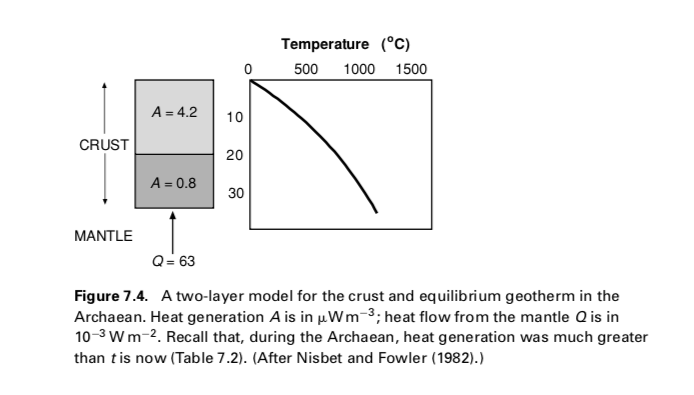

# Plot analytical solution

An analytical solution for this problem exists, and may be derived by integrating the heat flux equation twice against constraints on surface (or mantle, here) heat flux and temperature. Fowler present the solution in the form:


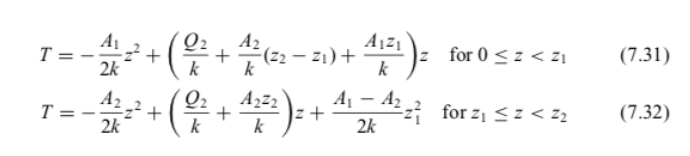


Here we will compare our 1D and 2D solutions to this analytical solution.


Text(0.5, 0, 'Temperature (C)')

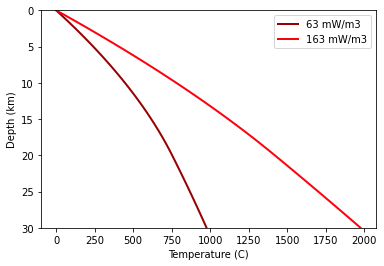

In [2]:
def heat_flux(z1,z2,A1,A2,k1,k2,Q2):
    z = np.linspace(0,z2,100)
    filt1 = z < z1
    T=np.zeros_like(z)
    T[filt1] = (-A1*z[filt1]**2)/(2*k1) + z[filt1]* (Q2/k1 + (A2/k1)*(z2-z1) + A1*z1/k1)
    T[~filt1]= (-A2*z[~filt1]**2)/(2*k2) + z[~filt1] * (Q2/k2 + A2*z2/k2) + (A1 - A2)*(z1**2)/(2*k2)
    return(z/1e3,T)

z,T = heat_flux(20e3,30e3,4.2e-6,0.8e-6,3.0,3.0,63e-3)
z2,T2 = heat_flux(20e3,30e3,4.2e-6,0.8e-6,3.0,3.0,163e-3)
plt.plot(T,z,color="xkcd:blood red",linewidth=2,label="63 mW/m3")
plt.plot(T2,z2,color="xkcd:bright red",linewidth=2,label="163 mW/m3")
plt.ylim(np.max(z),0)
plt.legend()
plt.ylabel("Depth (km)")
plt.xlabel("Temperature (C)")

# 1D simulation
Note - for the 1D time-dependent problem, we have more free parameters. In particular, the full form of the 1D time-dependent heat flow equation is:

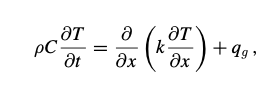

Here you can see density (rho) and specific heat (C) are listed - these are generally folded in the thermal conductivity k to form thermal diffusivity. However, in a lattice boltzmann formulation, these terms scale the source term (heating term, which is q in the above equation), and also the relaxation time and thus timescales, so need to be treated self-consistently. We adopt reasonable geological values below, and show the results converge closely to Fowler's results over long timescales. 

We run the problem for 50 Myr to allow equilibration, with timesteps of 10,000 yrs. Other parameters listed below.


In [3]:
#Time discretisation
age = 50 #Age in Myrs
#tstep=1000 #Number of timesteps
#dt = age*M2S/tstep
dt = 10000.0*M2S/1e6 # in sec
tstep=age*M2S/dt #in sec
print("Number of steps:",tstep,dt)

#Mesh discretisation
m=300  # Number of x divisions
dx=100.0 #Size of grid spacing


#Initial/boundary and heating properties
H=0. # internal heat production
Tinit = 600 # Initial temperature
TSurf = 0.0 #Surface temperature

dens1=2600
dens2=2950
C=1000 #* 0.413 #(1/(np.sqrt(2)*np.sqrt(3)))  # Scale factor for heat flux is 410/1000 - why?

Z1=20e3
Z2=30e3
A1=4.3e-6/(dens1*C) #Note we are scaling these to the source term here
A2=0.8e-6/(dens2*C)
print("Heat production:",A1,A2)
k1=3.0
k2=3.0
Q2=63e-3  # What is scaling for Q2? 
K1 = k1/(dens1*C)
K2 = k2/(dens2*C)
print("Thermal diff:",K1,K2)


Number of steps: 5000.0 315576000000.0
Heat production: 1.653846153846154e-12 2.711864406779661e-13
Thermal diff: 1.1538461538461538e-06 1.016949152542373e-06


In [4]:
# Simulation 1, Q=63 mW/m3

#T_5000=T1
#T_1000c = T1
LBS = pLB.init_1D_LB(dt,dx,tstep,m,Tinit,TSurf,H,Q2,K1,k1)
x=LBS['x']
print(np.size(x),m,x[m])

# Simulation II - structure defined above
H1 = np.ones_like(x) * A2  #Note H is now being used as an array - can be constant or x-like array
H1[ x <= Z1] = A1

# Note Heat production previously scaled by the following:
# H(W/kg)*dens = W/m3 = qg.
# Source S = qg/dens*C --> H*dens/dens*Cp --> H/Cp

LBS1 = pLB.init_1D_LB(dt,dx,tstep,m,Tinit,TSurf,H1,Q2,K1,k1)
T_Flux63=pLB.LB1D_Qbase(LBS1)
x1=LBS1['x']


301 300 30000.0


In [5]:
# Simulation 2, Q = 163 mW/m3
Q163=163e-3
LBS1 = pLB.init_1D_LB(dt,dx,tstep,m,Tinit,TSurf,H1,Q163,K1,k1)
T_Flux163=pLB.LB1D_Qbase(LBS1)

Text(0, 0.5, 'Depth (km)')

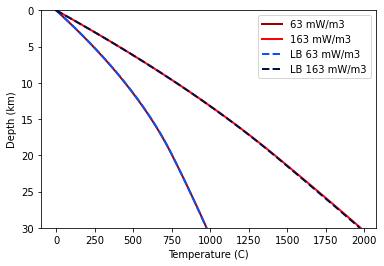

In [6]:
# Plot analytical first, dashed lines
plt.plot(T,z,color="xkcd:blood red",linewidth=2,label="63 mW/m3",linestyle="-")
plt.plot(T2,z2,color="xkcd:bright red",linewidth=2,label="163 mW/m3",linestyle="-")

# Now plot simulation results
plt.plot(T_Flux63,x1/1e3,color="xkcd:electric blue",linestyle="--",linewidth=2,label="LB 63 mW/m3")
plt.plot(T_Flux163,x1/1e3,color="xkcd:navy blue",linestyle="--",linewidth=2,label="LB 163 mW/m3")
plt.ylim(np.max(x1)/1e3,0)
plt.legend()
plt.xlabel("Temperature (C)")
plt.ylabel("Depth (km)")


# A 2D simulation

In using D2Q9 in 2D, care must be taken with the streaming step if the lattice velocities (c= dx/dt) are not unity. This occurs fairly generally in dimensional problems (eg. dx = 100 m, dt = 1000 yrs or somesuch). In these cases the lattice velocity is not one and thus the streaming of properties can't *i always* just proceed by using np.roll(f,1) (see Mohamad 2019 for some details on this).  
As a result, sometimes you need to scale your problem, and this is particularly the case for large viscosity at planetary scales. 
We give an example here for a 2D crustal profile conductive case. 
The basic similarity condition of the problem is:





$$ \frac{\kappa  t} {{d}^2} \equiv \frac{\kappa_{LB}  t_{LB}} { {{d}_{LB}}^2}$$


Note that $t_{LB}$ is equivalent to dt.M where M is the number of timesteps, and dt(=1) is the timestep. The timestep will probably end up quite small for this problem - grab a coffee while it runs. Similarly for $d_{LB}$, which is equal to dx.N, again where dx ideally equals 1 for the scaled problem.
In the following problem we've scaled the time and length scales, but left the temperatures largely as is. Note these require a scaling of $\kappa$, and also the thermal inputs for heat production (S) and input flux Q. Here we show how the heat production is scaled in a simple example, and compare against a benchmark.

The basic units of heat flow are $W/{m}^3$, and note for LBM this is generally scaled by $\frac{A}{\rho C}$.

In this case the units simplify to K/s (Kelvin/seconds). Using our scaling information, and assuming time scales are 
$t' = {d'}^2/\kappa'$,
then  

$$ {S} \sim \frac{ {\Delta T'} {\kappa'} } {{d'}^2} $$   
Noting that the scaling for d' is 0.10 (dimensional -> LB), the scaling for $\kappa'$ is ${10}^6$ (roughly, depending on the actual $\kappa$ calculate), and the scaling for temperature is $\frac{1}{{T}_{base}} $, then 

$$ {S}_{dim} \to \times \frac{{d'}^2}{ {T}_{base} \kappa'} \to {S}_{LB} $$


We employ this scaling below and compare to the analytical solution.

The problem involves a system held at constant top and bottom temperatures of 0 and 600 respectively. The crust is 30 km thick and has a heat production of A = ${9.6x10}^{-10}$ (W/kg, or ${4.2x10}^{-6} W/{m}^3).$ 

In [7]:
#Time discretisation
age = 15 #Age in Myrs
#tstep=1000 #Number of timesteps
#dt = age*M2S/tstep
dt = 10000.0*M2S/1e6 # in sec
mstep=age*M2S/dt #in sec
#dt=1
scale_t = 10000.0*M2S/1e6
mstep=5000
print("Number of steps:",mstep,dt)

#Mesh discretisation
m=300  # Number of x divisions
n=300
dx=100.0 #Size of grid spacing
dy=100.0
scale_x=100

#Scale problem###################################################
depth = 30e3
K_d=1.1538461538461538e-06

dim_side = K_d*age*M2S/(depth)**2

N=300
K_nd=1
# then time steps M
M = int(dim_side*(N**2)/K_nd)
print("timesteps",M)

d_star = depth/N
mstep=M
dx=1
dy=1
dt=1
ck=dx/dt
csq=ck*ck 
################################
########################################################################
#Initial/boundary and heating properties
H=0. # internal heat production
Tinit = 600 # Initial temperature
TSurf = 0.0 #Surface temperature
Qbase = (63e-3) *(1/3)* 100 # scaled to problem LB dT/dz (1./3)

dens1=2600
dens2=2950

k1=3.0
k2=3.0
C=1000  
K1 = k1/(dens1*C)
K2 = k1/(dens2*C)
kappa=K1 #placeholder

Z1=20e3
Z2=30e3
#K=1e-6
print("Scale:",(d_star**2)/K1*(1/1.153846))
Hnd = ((d_star**2)/(K1*(1/1.153846)))/Tinit  #Scaling factor for heat production
#A1d=4.2e-6/(dens1*C)
A1d= 9.6e-10
A2d=A1d
#Mantle is 7.38×10−12 W/kg
# Basalt Hc = 2.6 × 10−11 W kg−1
# Hc = 9.6 × 10−10 W kg−1
print("Compare H, Granite: Hc = 9.6 × 10−10 W kg−1.  This prob:",4.2e-6/(dens1*C) )
A1= Hnd * A1d 
A2=A1

print("Heat production:",A1,A2)
print("Thermal diff:",K1,K2)

omega=1.0/(3*K1/(dt*csq)+0.5) 
print("Omega:",omega)

#### Analytical model######################
ya1 = np.linspace(0,30e3,100)
A5d = A1d  #*500
yb = np.max(ya1)
c1 = (k1*Tinit/yb + dens1*A5d*yb/2 )
Ta1 =  c1*ya1/k1 - dens1*A5d*(ya1**2)/(2*k1)  #This seems a bit low/linear for high A
ya1 /= 1e2
ya1 = ya1[::-1]
#############################################
# Init once to get x, to define spatially varying quantities
LBS = pLB.LB_D2Q9_init_ThermHF(dt,m,n,dx,dy,mstep,TSurf,Tinit,H,Qbase,kappa,k1)
y=LBS['y']

H = np.ones_like(y) * A2  #Note H is now being used as an array - can be constant or x-like array
kappa = np.ones_like(y) * K1
H[ (y) >= Z1] = A1
kappa[(y)>=Z1] = K2  #Note surface is a 30km for this calculation

# Now init again with spatially varying A and kappa sorted. 

#For scaling
kappa *= 1e6
LBS = pLB.LB_D2Q9_init_ThermHF(dt,m,n,dx,dy,mstep,TSurf,Tinit,H,Qbase,kappa,k1)
X=LBS['x']

T=np.ones_like(LBS['T'])

T1 = T * np.linspace(Tinit,0,m+1)

LBS = pLB.reinit_T_f(LBS,T1)

mstep=LBS['mstep']
#mstep=2500
print(mstep)
T=LBS['T']
f=LBS['f']



Number of steps: 5000 315576000000.0
timesteps 54618
Scale: 7511112112.592726
Compare H, Granite: Hc = 9.6 × 10−10 W kg−1.  This prob: 1.6153846153846152e-12
Heat production: 0.015999997866666667 0.015999997866666667
Thermal diff: 1.1538461538461538e-06 1.016949152542373e-06
Omega: 1.9999861539420112
54618


# Plot initial conditions

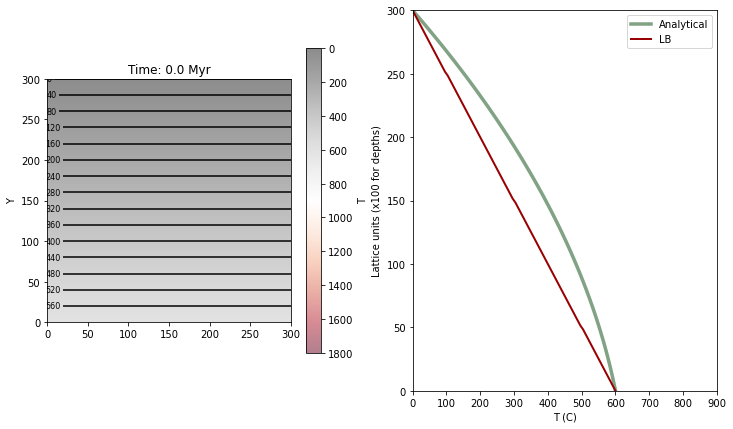

In [8]:
from scipy.interpolate import griddata

def plot_pic(lb_s,t,i,ya1,Ta1):
    plt.figure(figsize=(12,7))
    plt.ylabel("Y")
    plt.xlabel("X")
    X=LBS['x']
    Y=LBS['y']
    plt.subplot(1,2,1)
    con1 = plt.contour(X,Y,T,15,colors='black')
    plt.clabel(con1,inline=True,fontsize=8)
    plt.ylabel("Y")
    t2=t*10/31557
    plt.title("Time: {} Myr".format(t2))
    plt.imshow(T.T, extent=[0, n*dx, 0, m*dx], origin='lower', cmap='RdGy_r', alpha=0.5,vmin=0,vmax=1800)
    #plt.colorbar();
    cbar=plt.colorbar(label='T',shrink=0.8);
    cbar.ax.invert_yaxis() 

    plt.subplot(1,2,2)
    plt.plot(Ta1,ya1,color="xkcd:forest green",alpha=0.5,linewidth=3.5,label="Analytical")
    y = np.linspace(300,0,100)
    x = np.ones_like(y)*150
    T1D = griddata( (X.ravel(),Y.ravel()), T.ravel(), (x,y), method='nearest')

    plt.plot(T1D,y,color="xkcd:blood red",linewidth=2,label="LB")
    plt.ylim(0,300)
    plt.xlim(0,900)
    plt.ylabel("Lattice units (x100 for depths)")
    plt.xlabel("T (C)")
    plt.legend()
    name="thermal_profile"+str(i)+".png"
    #plt.savefig(name)  #Uncomment this line if you'd like to save outputs.
    #plt.close()  # Uncomment if you'd like to close figure instances between plots. 
    #plt.clf()
    
    
plot_pic(LBS,0,0,ya1,Ta1)

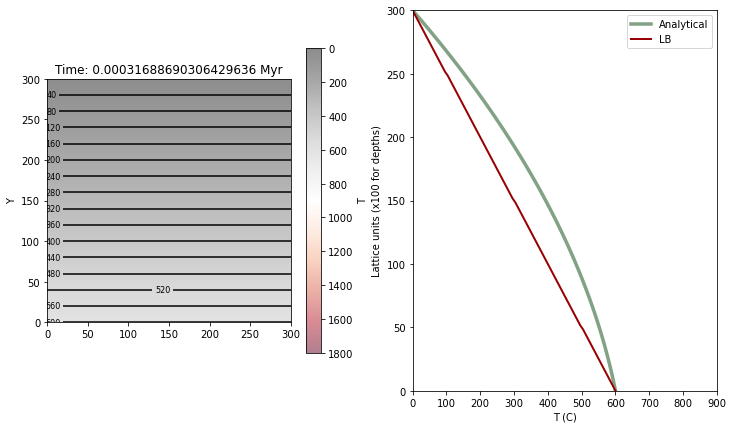

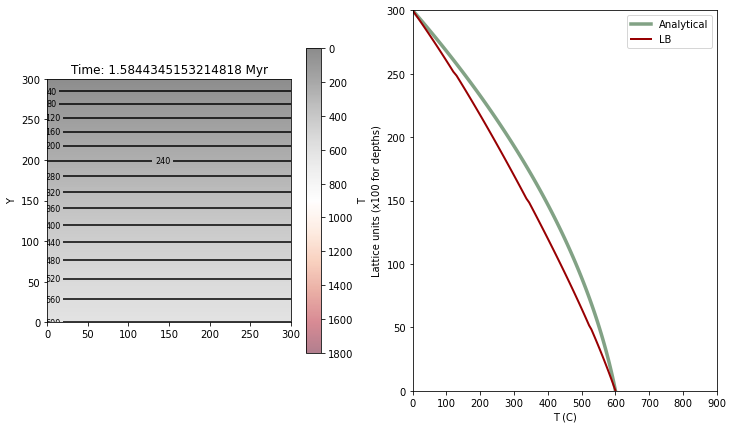

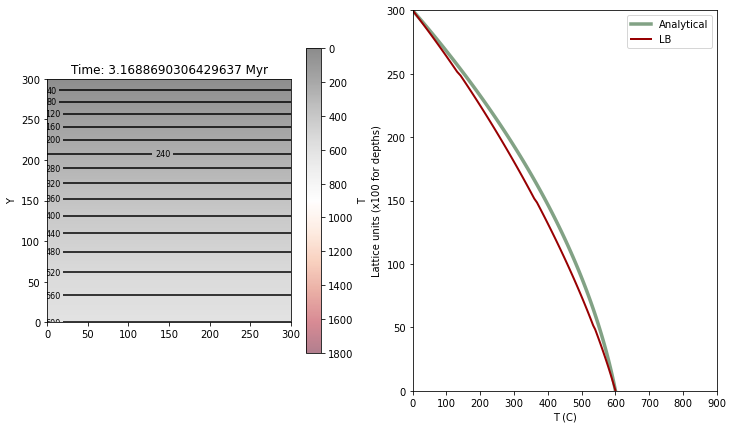

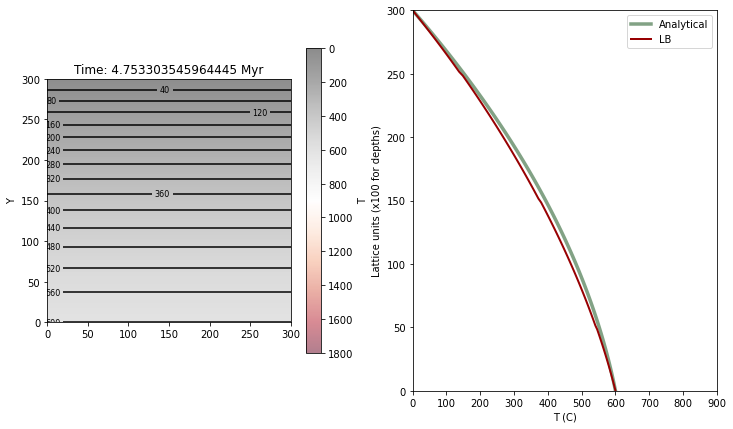

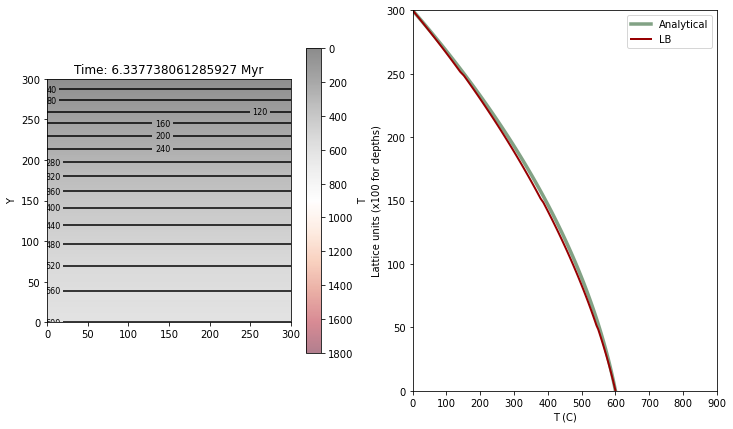

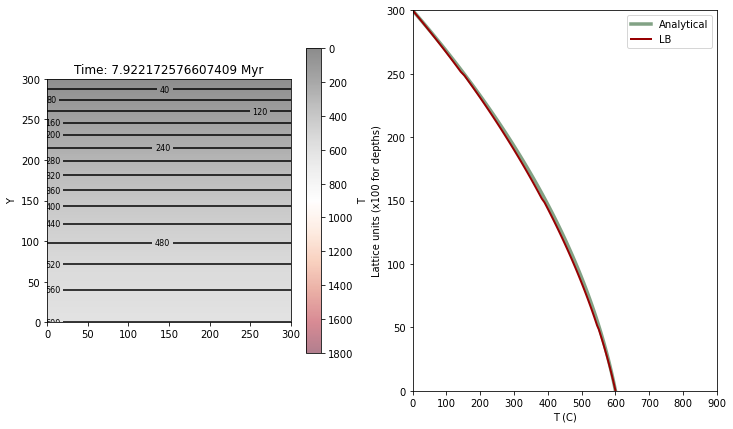

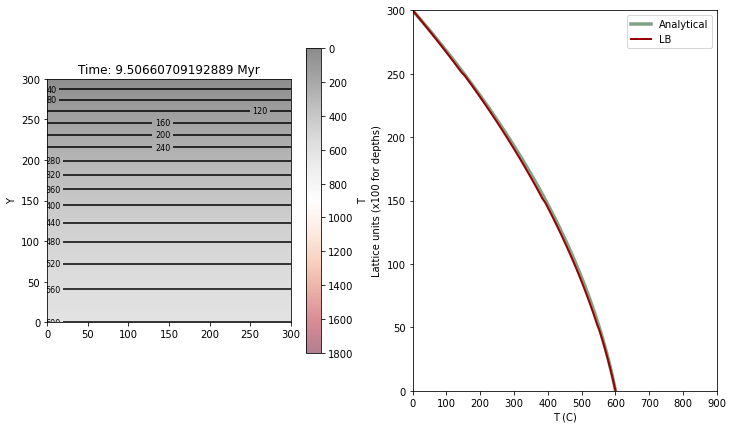

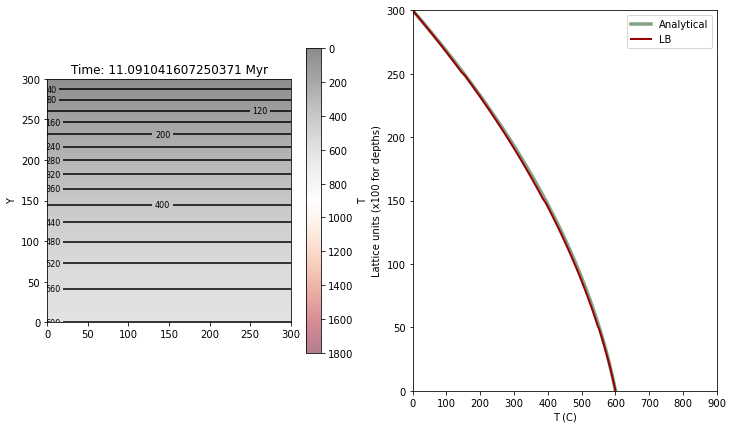

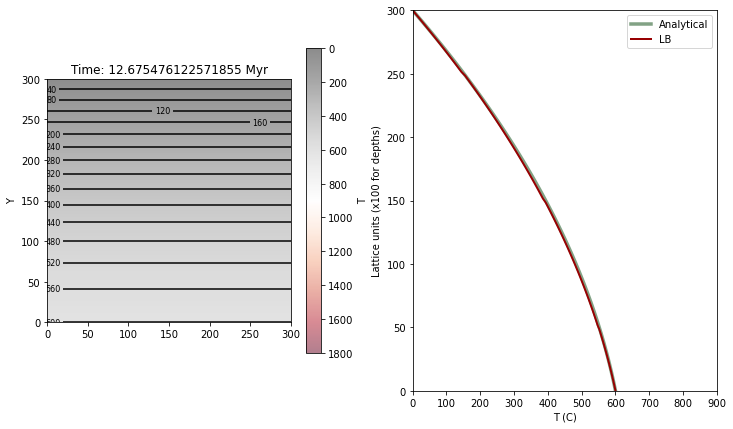

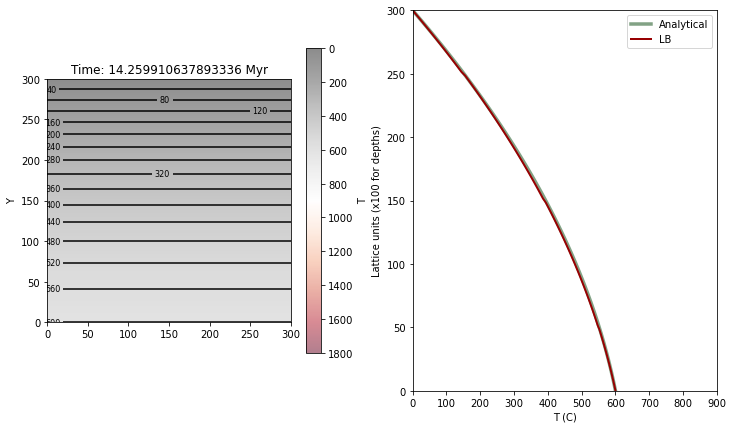

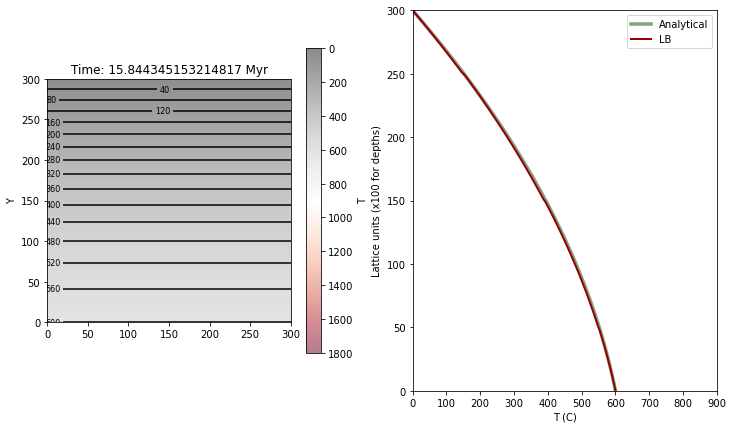

In [9]:
# Run the simulation - this could take a little while depending on the requested number of timesteps :)

timesteps = dt*np.arange(1,mstep+1,1)
omega=1.0/(3*kappa/(dt*csq)+0.5) 

export_step=5000

i=0
j=0
for t in timesteps:
    if i > 0:
     LBS['T']=T
     LBS['f']=f
    LBS =  pLB.LB_D2Q9_T_HF(LBS,0,0) #Top, Base. 0=const temp, >1=const flux.
    T=LBS['T']
    f=LBS['f']
    i+=1
    if (i==1):
        plot_pic(LBS,t,j,ya1,Ta1)
    if i % export_step == 0:
        j += 1
        plot_pic(LBS,t,j,ya1,Ta1)
            
#print(T)


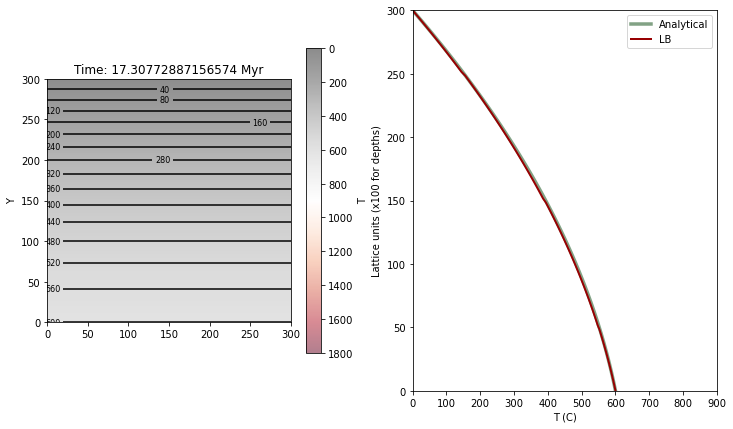

In [10]:
# Plot final timestep:
plot_pic(LBS,t,j,ya1,Ta1)